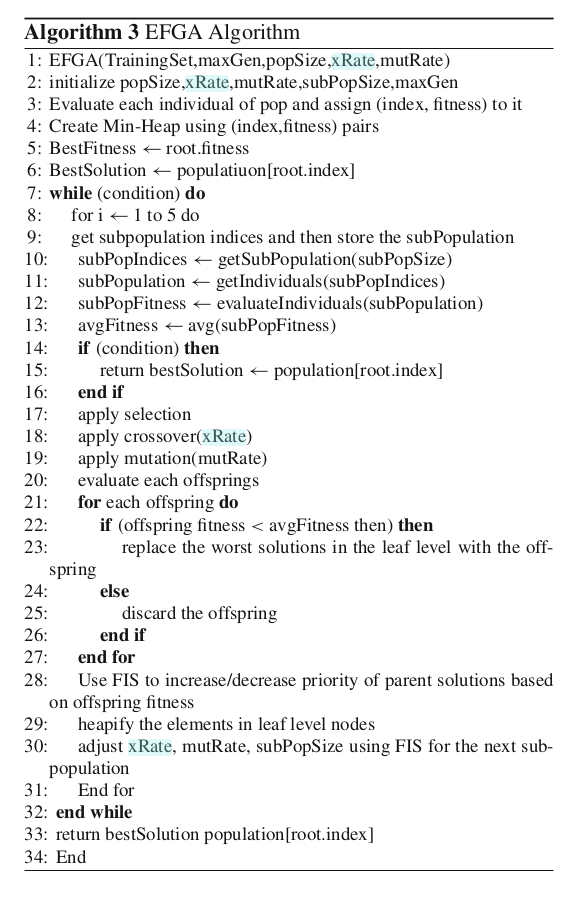

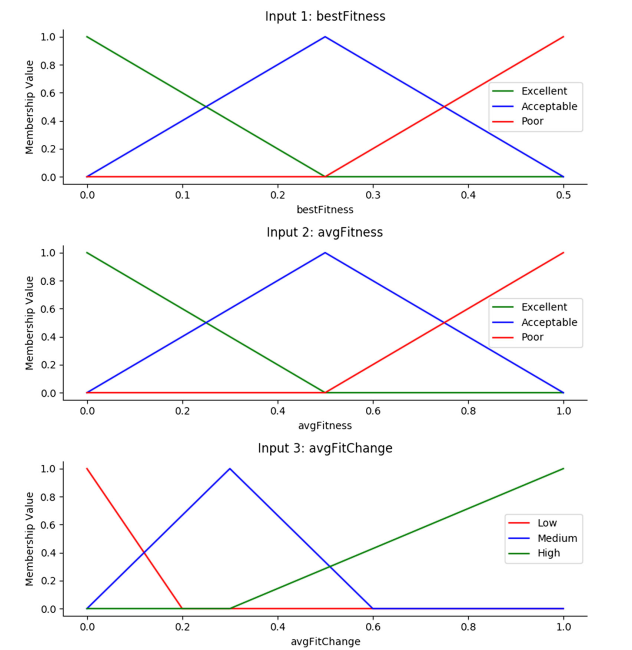
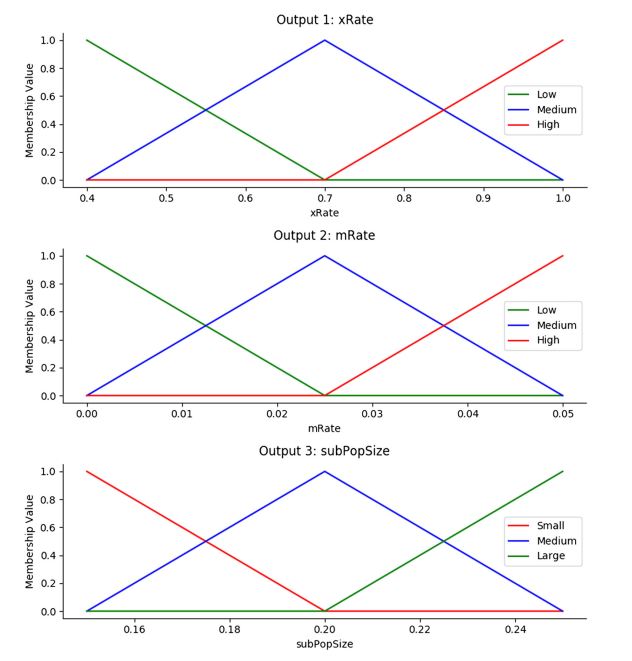

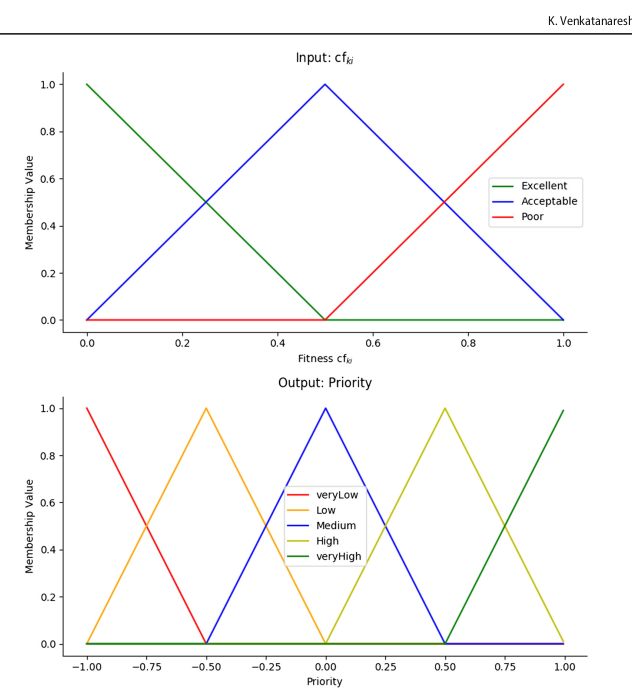


TODO: 
1) Implement minheap and test it - Done
2) Minimization relative fitness value (let's say that we have error, how do we calculate fitness value) - Done
3) Implement fuzzy sets for: bestFitness, xRate,mutRate, subPopSize, priority: very low-very high - Done
4) Implement fuzzy rules. - Done. 
5) Implement crossover
6) Implement mutation


In [1]:
import heapq as hq
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from src.elegant_fuzzy_genetic_algorithms.helpers.heap_helpers import (create_heap, replace_leaves_with_children, 
                                                                       approximate_topk_indices, update_parents_with_indices)
from src.elegant_fuzzy_genetic_algorithms.helpers.param_inference import ParamInference
from src.elegant_fuzzy_genetic_algorithms.conf.param_inference_config import Conf
from src.common.utils import (quadratic_fitness, _mutate_single_point, crossover_2)
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [3]:
Conf.default_params

{'xRate': 0.7, 'mRate': 0.025, 'subPopSize': 0.2}

In [4]:
priority_inferencer =  ParamInference(rule_path_param=Conf.rule_path_param, rule_path_priority=Conf.rule_path_priority)
priority_inferencer.infer(.025, .045, .7)

{'xRate': 0.5007540322580648,
 'mRate': 0.00839616935483871,
 'subPopSize': 0.1601508064516129}

In [5]:
def objective(x):
 x, y = x
 return -20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2))) - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))) + np.e + 20

In [6]:
def crossover_3(p1, p2):
    return np.array([p1[0], p2[1]]), np.array([p2[0], p1[1]]),

In [7]:
def schwefel(genome):
    return np.abs(418.9829 * genome.shape[0] - np.sum(genome * np.sin(np.sqrt(np.abs(genome)))))

In [8]:
schwefel(np.array([1, -50000]))

25455.5976323273

In [24]:
class SimulationConfig: 
    mutation_scale: float = 2
    x_range: float = 2000

In [25]:
def mutation(loc,):
    def _mutation(genome):
        return genome + np.random.normal(loc, scale=3)
    return _mutation

In [26]:
def simulation(  N = 50, epochs: int =  100, verbose = False, default_params = Conf.default_params, conf: SimulationConfig = SimulationConfig()):
    params = default_params
    n_subpop_individuals = np.round(N * params['subPopSize']).astype(int)
    
    
    genomes = np.random.uniform(low=-conf.x_range, high=conf.x_range, size=(N, 5))
    fitness = np.apply_along_axis(schwefel, 1, genomes)
    worst_initial_fitness = np.max(fitness)
    fitness = fitness / worst_initial_fitness
    heap = create_heap(fitness)
    best_fitness = heap[0][2]
    history = []
    
    for i in tqdm(range(epochs)):
        # Indices of parents in heap & fitness
        topk = np.arange(n_subpop_individuals)
        subpop_fitness = np.array([heap[topk[i]][2] for i in range(n_subpop_individuals)])
        
        # Indices of parents in genome array    
        topk_indices = [heap[topk[i]][1] for i in range(n_subpop_individuals)]
        
        # Calculate best fitness
        avg_fitness = np.mean(subpop_fitness)
        
        # In case topk is uneven we take the even subpop
        # 
        crossover_indices = topk[:(n_subpop_individuals // 2) * 2]
        
        # Shuffle & select pairs for crossover
        np.random.shuffle(crossover_indices)
        parent_1, parent_2 = crossover_indices[::2], crossover_indices[1::2]
        do_crossover = np.random.rand(parent_1.shape[0]) < params['xRate']

        while not do_crossover.any():
            do_crossover = np.random.rand(parent_1.shape[0]) < params['xRate']

        
        # Parent 1 and parent 2 to do crossover
        # 
        parent_1 = parent_1[do_crossover]
        parent_2 = parent_2[do_crossover]
        
        child_genomes = []
        for i in range(parent_1.shape[0]):
            # Getting genomes of the parent pair
            p1 = genomes[heap[parent_1[i]][1]]
            p2 = genomes[heap[parent_2[i]][1]]
            
            c1, c2 = crossover_2(p1, p2)
            child_genomes += [c1, c2]
        child_genomes = np.array(child_genomes)
        
        # Mutation
        mutate = np.random.rand(child_genomes.shape[0]) <= params['mRate']


        if mutate.sum():
            child_genomes[mutate] =  np.apply_along_axis(mutation(conf.mutation_scale), 1, child_genomes[mutate])
            
            
        # Calculating children fitness, replacing worst solutions with good childre
        prev_avg_fitness = np.mean([i[2] for i in heap])
        child_fitness = np.apply_along_axis(schwefel, 1, child_genomes) / worst_initial_fitness
        use_to_replace = child_fitness < avg_fitness
        
        if use_to_replace.sum():
            genomes, heap = replace_leaves_with_children(solutions=genomes, heap=heap, children=child_genomes[use_to_replace], children_fitness=child_fitness[use_to_replace])
    
        # updating parent priorities & mutating parents
        priority_updates = []
        parent_indices = []
        for i in range(parent_1.shape[0]):
            c1_fitness, c2_fitness = child_fitness[i * 2], child_fitness[i * 2 + 1]
            priority_update = -priority_inferencer.infer_priority(c1_fitness, c2_fitness)
            priority_updates += [priority_update, priority_update]
            parent_indices += [parent_1[i], parent_2[i]]
    
            # Mutating parent genomes
            indices = [parent_1[i], parent_2[i]]
            mutate = np.random.rand(2) < params['mRate']
    
            for j in range(len(indices)):
                 if mutate[j]:
                    index_to_mutate = heap[indices[j]][1]
                    genomes[index_to_mutate] = mutation(conf.mutation_scale)(genomes[index_to_mutate])
        
        
        # Parent priorities updated, heap heapified
        heap = update_parents_with_indices(heap=heap, parent_indices=parent_indices, update_values=priority_updates)
        hq.heapify(heap)
    
        cur_avg_fitness = np.mean([i[2] for i in heap])
        avg_fit_change = prev_avg_fitness - cur_avg_fitness
        
    
        params = priority_inferencer.infer(bestFitness=best_fitness, avgFitness=avg_fitness, avgFitChange=avg_fit_change)

        if verbose:
            print(f'Best solution: {genomes[heap[0][1]]}, fitness: {heap[0][2]}, avg fitness: {cur_avg_fitness}')
        
        history.append({'best_fitness': schwefel(genomes[heap[0][1]])/worst_initial_fitness, 'avg_fitness': cur_avg_fitness})
    
        
    
    return pd.DataFrame.from_records(history), genomes[heap[0][1]]
        


In [27]:
history, best_solution = simulation(epochs=500)

100%|██████████| 500/500 [00:08<00:00, 58.73it/s]


In [28]:
schwefel(best_solution)

23.663218591956593

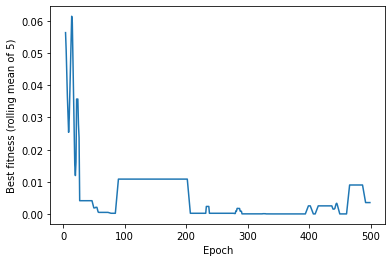

In [29]:
plt.plot(history.best_fitness.rolling(5).mean())
plt.xlabel('Epoch')
plt.ylabel('Best fitness (rolling mean of 5)')
plt.show()

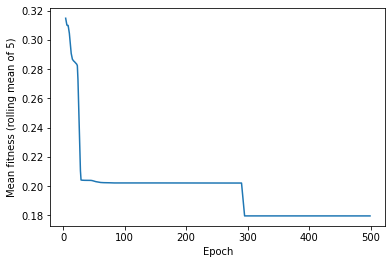

In [30]:
plt.plot(history.avg_fitness.rolling(5).mean())
plt.xlabel('Epoch')
plt.ylabel('Mean fitness (rolling mean of 5)')
plt.show()